# Assigment 2: Detecting Contradictions in Law Documents            
We have a Slovene dataset and English dataset, we can work with either or combine both. The ultimate goal is to create a system that could be used by legal professionals: when drafting a new section of a law or contract, the system should automatically identify potentially contradisting extisting sections.

In [ ]:
import numpy as np
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns

## Task 1 - Data preparation and exploration       
Load the provided JSONL datasets, transform them into a format suitable for use with your model. For the **Slovene** dataset, this may involve *creating pairs of sections with binary labels (contradicting/not contradicting)*. For the **English** dataset, use the provided labels directly or merge classes into binary categories if appropriate.  

In [4]:
# for now, I'll be using only the English dataset (maybe later Slovene also)
# loading the dataset - english one has two files - train and test
en_train = pd.read_json('Seminar 2 datasets/data/English dataset/train.jsonl', lines=True)
en_test = pd.read_json('Seminar 2 datasets/data/English dataset/test.jsonl', lines=True)

#print(en_train.head())

# we dont need doc_id or key
en_train = en_train.drop(columns=['doc_id', 'key'])
en_test = en_test.drop(columns=['doc_id', 'key'])

labelVal_train = en_train['label'].value_counts()
labelVal_test = en_test['label'].value_counts()

print(labelVal_train)
print(labelVal_test)


label
Entailment       3530
NotMentioned     2820
Contradiction     841
Name: count, dtype: int64
label
Entailment       968
NotMentioned     903
Contradiction    220
Name: count, dtype: int64


Perform basic exploratory analysis: the questions to answer:      
* Are there missing values or duplicate entries?      
* How many examples are in the chosen dataset?
* How long are typical sections?
* Are contradictions balanced across the datasets?

In [5]:
missing_or_empty_train = en_train.isnull() | (en_train == "")
total_issues = missing_or_empty_train.sum()
print(f"Missing or empty values (like empty strings) in train set:\n{total_issues}")
missing_or_empty_test = en_test.isnull() | (en_test == "")
total_issues = missing_or_empty_test.sum()
print(f"Missing or empty values (like empty strings) in test set:\n{total_issues}")

# so: there are no 'missing values' but there are empty strings in column 'premise' -> label: NotMentioned

# if we drop them
en_train = en_train[en_train["premise"] != ""]
en_test = en_test[en_test["premise"] != ""]

labelVal_train = en_train['label'].value_counts()
labelVal_test = en_test['label'].value_counts()

print(labelVal_train)
print(labelVal_test)


Missing or empty values (like empty strings) in train set:
premise       2820
hypothesis       0
label            0
dtype: int64
Missing or empty values (like empty strings) in test set:
premise       903
hypothesis      0
label           0
dtype: int64
label
Entailment       3530
Contradiction     841
Name: count, dtype: int64
label
Entailment       968
Contradiction    220
Name: count, dtype: int64


In [6]:

# checking for the duplicates
dupl_train = en_train.value_counts()
dupl_train = dupl_train[dupl_train > 1]
print(dupl_train)

dupl_test = en_test.value_counts()
dupl_test = dupl_test[dupl_test > 1]
print(dupl_test)


premise                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     hypothesis                                                  

In [7]:
# getting rid of duplicates
en_train = en_train.drop_duplicates(keep="first")
en_test = en_test.drop_duplicates(keep='first')

In [8]:
# how many examples in a chosen dataset
print(f"Examples in a train set: {len(en_train)}")
print(f"Examples in a test set: {len(en_test)}")

Examples in a train set: 4292
Examples in a test set: 1165


In [9]:
# length of typical sections
en_train["premise_len"] = en_train["premise"].str.len()
en_train["hypothesis_len"] = en_train["hypothesis"].str.len()
en_test["premise_len"] = en_test["premise"].str.len()
en_test["hypothesis_len"] = en_test["hypothesis"].str.len()

print(en_train[["premise_len", "hypothesis_len"]].describe())
print(en_test[["premise_len", "hypothesis_len"]].describe())


       premise_len  hypothesis_len
count  4292.000000     4292.000000
mean    489.243942       98.609273
std     339.184711       27.187489
min      36.000000       66.000000
25%     262.000000       80.000000
50%     393.000000       95.000000
75%     606.000000      119.000000
max    3098.000000      162.000000
       premise_len  hypothesis_len
count  1165.000000     1165.000000
mean    487.676395       98.139914
std     353.770771       27.346670
min      64.000000       66.000000
25%     244.000000       80.000000
50%     382.000000       90.000000
75%     619.000000      119.000000
max    2489.000000      162.000000


In [10]:
# are contradictions balanced across datasets?
# normalize shows percentage
print(en_train["label"].value_counts(normalize=True))
print(en_test["label"].value_counts(normalize=True))
# they are, around 80% entailment and 20% contradiction

label
Entailment       0.805918
Contradiction    0.194082
Name: proportion, dtype: float64
label
Entailment       0.813734
Contradiction    0.186266
Name: proportion, dtype: float64


Split the data into **train**, **validation**, and **test** sets. Prepare tokenized text representations suitable for traditional machine learning models.       
Additionally, include a short **data presentations and visualization section**. Visualize the data distribution, text lengths, and example contradictions using tables and graphs.

In [11]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\leakr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leakr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leakr\AppData\Roaming\nltk_data...


True

In [12]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# function from labs
# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())  # Convert text to lowercase

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Stemming (uncomment if you want to use stemming)
    stemmed_words = [stemmer.stem(word) for word in words]

    # Join the words back into a string
    preprocessed_text = ' '.join(lemmatized_words)
    return preprocessed_text


In [17]:
en_train['clean_premise'] = en_train['premise'].apply(preprocess_text)
en_train['clean_hypothesis'] = en_train['hypothesis'].apply(preprocess_text)

en_test['clean_premise'] = en_test['premise'].apply(preprocess_text)
en_test['clean_hypothesis'] = en_test['hypothesis'].apply(preprocess_text)

In [ ]:
from sklearn.model_selection import train_test_split

# train and validate set
X_train, X_val, y_train, y_val = train_test_split(
    en_train[['clean_premise', 'clean_hypothesis']], 
    en_train['label'], 
    test_size=0.2, 
    random_state=42
)

X_train = X_train.reset_index(drop=True)
X_val   = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val   = y_val.reset_index(drop=True)

# test set
X_test = en_test[['clean_premise', 'clean_hypothesis']].reset_index(drop=True)
y_test = en_test['label'].reset_index(drop=True)

In [23]:
X_test.head()

,clean_premise,clean_hypothesis
0,recipient shall immediately return redeliver t...,receiving party shall destroy return confident...
1,right license whether expressed implied confid...,agreement shall grant receiving party right co...
2,purpose agreement confidential information mea...,confidential information shall include technic...
3,purpose agreement confidential information mea...,confidential information shall expressly ident...
4,notwithstanding foregoing party duty hold conf...,obligation agreement may survive termination a...


## Data visualization

<Axes: title={'center': 'Test label distribution'}, xlabel='label'>

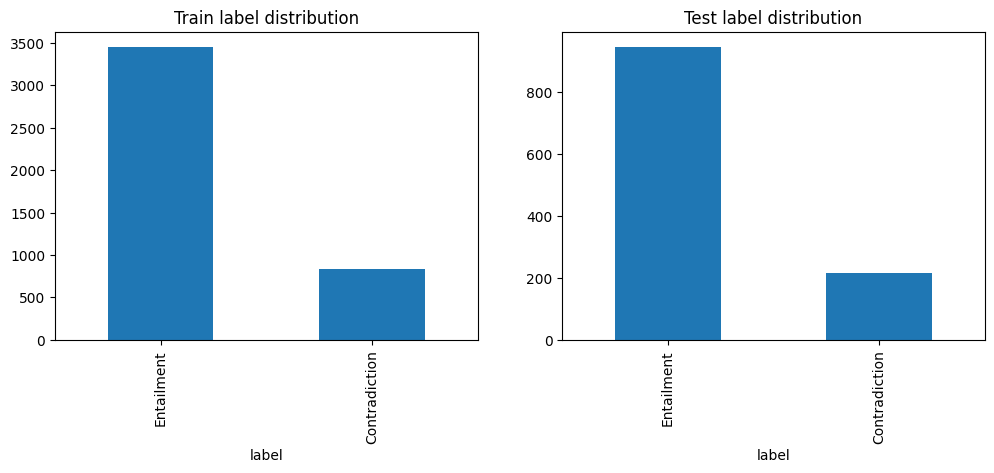

In [26]:
# Label distributions (train vs test)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
en_train['label'].value_counts().plot(kind='bar', ax=axes[0], title='Train label distribution')
en_test['label'].value_counts().plot(kind='bar', ax=axes[1], title='Test label distribution')

Text(0.5, 1.0, 'Hypothesis length (train)')

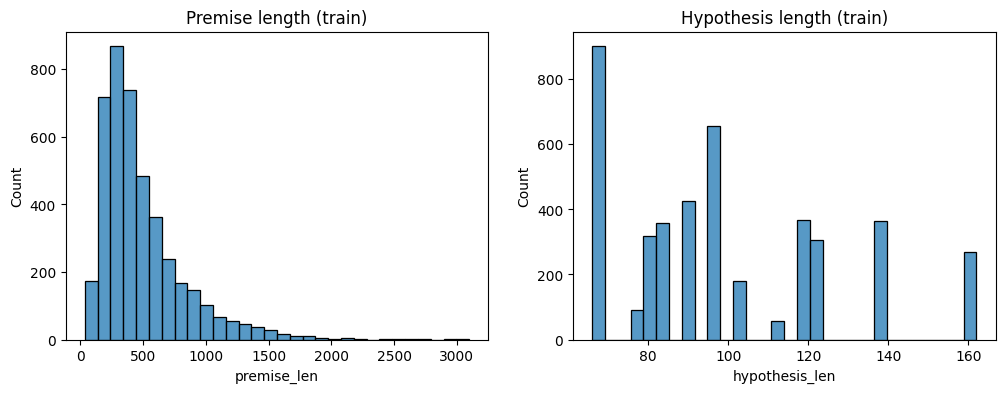

In [34]:
# Histograms of text lengths (train)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(en_train['premise_len'], bins=30, ax=axes[0])
axes[0].set_title('Premise length (train)')
sns.histplot(en_train['hypothesis_len'], bins=30, ax=axes[1])
axes[1].set_title('Hypothesis length (train)')


In [43]:
# Show a few example contradictions from train set
display(en_train[en_train['label']=='Contradiction'][['premise','hypothesis']].sample(5))

,premise,hypothesis
3054,The receiving Party may disclose Confidential ...,Receiving Party may share some Confidential In...
4385,Recipient may use and disclose the Confidentia...,Receiving Party shall not use any Confidential...
3727,WHEREAS the Parties agree that Confidential In...,Confidential Information shall only include te...
1721,"(e) ""Confidential Information"" shall mean all ...",Confidential Information shall only include te...
3438,“Confidential Information” means any informati...,Confidential Information shall only include te...


# Task 2 - Basic Machine Learning

TO DO: apply hyperparameter tuning and cross-validation to improve model performance. !!!

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report

# concatenate text (could also vectorize each seperately - but then no context interchange, idk)
train_texts = X_train['clean_premise'] + ' ' + X_train['clean_hypothesis']
val_texts = X_val['clean_premise'] + ' ' + X_val['clean_hypothesis']
test_texts = X_test['clean_premise'] + ' ' + X_test['clean_hypothesis']

# vectorize using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(train_texts)
X_val_vec = vectorizer.transform(val_texts)
X_test_vec = vectorizer.transform(test_texts)

1. Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

# define model and train
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# evaluate
pred_val = model.predict(X_val_vec)

print("Logistic Regression Accuracy:", accuracy_score(y_val, pred_val))
print("\nClassification report:\n", classification_report(y_val, pred_val))

Logistic Regression Accuracy: 0.910360884749709

Classification report:
                precision    recall  f1-score   support

Contradiction       0.88      0.63      0.73       168
   Entailment       0.92      0.98      0.95       691

     accuracy                           0.91       859
    macro avg       0.90      0.80      0.84       859
 weighted avg       0.91      0.91      0.90       859



2. Decision Trees or Random Forests

3. Support Vector Machines (SVM)

### Results:

In [ ]:
# FINAL EVALUATION: train all three on test set and visualize accuracy comparison